# Assessing the Accuracy of ML Models

> **Warning**  
> The `"best_score_"` attribute in `GridSearchCV` refers to the cross-validation score obtained during the grid search.  
> This value is **not** the same as the balanced accuracy calculated afterward using the best model.  
> - `"best_score_"`: Computed on the cross-validation folds (training data).  
> - Balanced accuracy in evaluation: Computed on the hold-out **test** or **validation** data.


In [ ]:
from pathlib import Path
from pathlib import Path
from typing import Any
import os
import re
import sys
import pickle

import shap
import numpy as np
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

# Define the project root path
ROOT = Path(os.getcwd()).parent

# Add custom Python modules to the system path
sys.path.append(str(Path(ROOT, "Python")))

# Import custom utilities
from utils_cmatrix import CMatrix as cmatrix  # type: ignore
from utils_models import Model, Pipeline, Dataset  # type: ignore


d:\iranzo\doctorado_v2\classification


The notebook include several graphics. They could be saved inside `graphics_path`.

In [ ]:
graphics_path = Path(ROOT, "figures")

In [4]:
def search_dict(lst: list[dict] | pd.DataFrame, target_dict: dict) -> dict | pd.DataFrame:
    """
    Search for a matching dictionary inside a list of dicts or filter a DataFrame
    based on unique identifier keys.

    Parameters
    ----------
    lst : list[dict] | pd.DataFrame
        The collection to search (either a list of dictionaries or a DataFrame).
    target_dict : dict
        A dictionary containing the keys: "pred_id", "model", "pipe", "dataset".

    Returns
    -------
    dict | pd.DataFrame
        - If `lst` is a list: returns the unique matching dictionary.
        - If `lst` is a DataFrame: returns the filtered DataFrame.

    Raises
    ------
    ValueError
        If no unique match is found in the list case.
    """
    unique_id_keys = ["pred_id", "model", "pipe", "dataset"]
    pred_id, model, pipe, dataset = [target_dict[k] for k in unique_id_keys]

    if isinstance(lst, list):
        # Use a generator to avoid building an intermediate list
        matches = (
            d for d in lst
            if d.get("pred_id") == pred_id
            and d.get("model") == model
            and d.get("pipe") == pipe
            and d.get("dataset") == dataset
        )
        result = list(matches)

        if len(result) == 1:
            return result[0]
        raise ValueError("No unique dict found with the requested parameters.")

    elif isinstance(lst, pd.DataFrame):
        query = (
            f"(pred_id == '{pred_id}') "
            f"& (model == '{model}') "
            f"& (pipe == '{pipe}') "
            f"& (dataset == '{dataset}')"
        )
        return lst.query(query).copy()

    else:
        raise TypeError("lst must be either a list of dicts or a pandas DataFrame.")


Include the vegetation labels.

In [5]:
# Load label codes
label_codes_path = Path(ROOT, "data/labels/label_codes.csv")
label_codes = pd.read_csv(label_codes_path)

# Remove duplicates in the "code_v1_reclass" column.
# Using `drop_duplicates` avoids introducing unintended changes from `.max()`.
# Each unique "code_v1_reclass" will keep the first occurrence.
label_codes = (label_codes
    .drop_duplicates(subset="code_v1_reclass", keep="first")
    # Clean up the index after deduplication
    .reset_index(drop=True)
)

In [6]:
def set_version(dataset_version: int, lst: list[dict]) -> list[dict]:
    """
    Ensure each dict in `lst` has a 'dataset' key set to `dataset_version`.
    If the list is empty, it is returned unchanged.
    """
    if not lst:
        return lst

    # If any item lacks 'dataset', set it for all to keep the list consistent
    if not all("dataset" in d for d in lst):
        lst = [dict(d, dataset = dataset_version) for d in lst]
        # Remove version number of each predictor set id
        return [d | {"pred_id": d["pred_id"][:-2]} for d in lst]
    return lst


def _extract_version(text: str) -> int:
    """
    Extract the version number.
    """
    m = re.search(r"(\d+)_\d{8}T\d{6}$", text)
    if m:
        return int(m.group(1))

    raise ValueError(f"Could not extract trailing integer from: {text!r}")


def load_stats(
    folder_name: str
) -> tuple[pd.DataFrame, list[dict[str, Any]], dict[str, Any]]:
    """
    Read grid search stats, confusion matrices, and find the best model
    for a given results prefix.

    Parameters
    ----------
    folder_name : str
        Prefix of the results folder(s) inside ROOT/results/logs
        (e.g., 'train_dataset_v3_TIMESTAMP').

    Returns
    -------
    grid_best_stats : pd.DataFrame
        DataFrame loaded from 'best_gridcv_stats.csv' with a 'dataset' column ensured.
    cm_stats : list[dict]
        Confusion matrices stats list with 'dataset' injected if missing.
    best_model : dict
        Dict describing the best model, augmented for SVM to enable probability if needed.

    Raises
    ------
    FileNotFoundError
        If no matching results folder is found.
    ValueError
        If dataset version cannot be inferred from folder name.
    """
    logs_root = Path(ROOT, "results", "logs")
    candidates = list(logs_root.glob(f"{folder_name}*"))
    if not candidates:
        raise FileNotFoundError(f"No folders found matching: {logs_root / (folder_name + '*')}")

    # Choose the most recent matching folder by modification time
    folder_path = max(candidates, key=lambda p: p.stat().st_mtime)

    # Infer dataset version from the provided folder_name;
    # fall back to folder_path.name
    try:
        dataset_version = _extract_version(folder_name)
    except ValueError:
        dataset_version = _extract_version(folder_path.name)

    # Load pickled stats
    with open(folder_path / "gridcv_stats.pkl", "rb") as f:
        model_grid_stats: list[dict[str, Any]] = pickle.load(f)
        model_grid_stats = set_version(dataset_version, model_grid_stats)

    with open(folder_path / "confusion_matrices.pkl", "rb") as f:
        cm_stats: list[dict[str, Any]] = pickle.load(f)
        cm_stats = set_version(dataset_version, cm_stats)

    # Load best gridcv stats CSV and ensure 'dataset' column exists
    grid_best_stats = pd.read_csv(folder_path / "best_gridcv_stats.csv")
    if "dataset" not in grid_best_stats.columns:
        grid_best_stats["dataset"] = dataset_version
    # Remove dataset version from predictor ids
    grid_best_stats["pred_id"] = grid_best_stats["pred_id"].str[:-2]

    # Robustly select the best model (support 'best_score' or sklearn's 'best_score_')
    def _score(d: dict[str, Any]) -> float:
        return float(d.get("best_score", d.get("best_score_", float("-inf"))))

    best_model = max(model_grid_stats, key=_score)

    # For SVM, ensure probability=True to allow SHAP computation
    # on probabilities
    if best_model.get("model") == "svm":
        best_model.setdefault("best_params", {})
        best_model["best_params"]["probability"] = True

    return grid_best_stats, cm_stats, best_model

In [7]:
dataset_versions = [1, 2, 3]

best_grids: dict[str, dict] = {}
cm_stats: list[dict] = []
grid_best_stats_frames: list[pd.DataFrame] = []

for v in dataset_versions:
    folder_name = f"train_dataset_v{v}"

    grid_stats, cm_best, best_grid = load_stats(folder_name)
    best_grids[v] = best_grid
    cm_stats.extend(cm_best)
    grid_best_stats_frames.append(grid_stats)

# Concatenate all stats into one DataFrame
grid_best_stats = pd.concat(grid_best_stats_frames, ignore_index=True)


In [8]:
best_grids

{1: {'pred_id': 'vif_pca',
  'model': 'svm',
  'pipe': 'none_tomeklinks',
  'best_params': {'C': 25,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': np.float64(0.8085202331633632),
  'dataset': 1},
 2: {'pred_id': 'vif_global',
  'model': 'svm',
  'pipe': 'none_tomeklinks',
  'best_params': {'C': 15,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': np.float64(0.701095181759412),
  'dataset': 2},
 3: {'pred_id': 'vif_global',
  'model': 'svm',
  'pipe': 'none_tomeklinks',
  'best_params': {'C': 5,
   'gamma': 'auto',
   'kernel': 'rbf',
   'probability': True},
  'best_score': np.float64(0.7249841235857701),
  'dataset': 3}}

## Pipelines

View the error metrics by pipeline (separating under- and over-sampling techniques). If those that do not rebalance the sample end up with lower error metrics, cite studies that mention how poorly balanced samples can inflate error statistics.

In [37]:
# Function to plot grouped horizontal bars
def plot_grouped_bars(df, title, ax):
    colors = ["#212529", "#6c757d", "#ced4da"]

    dat_over = df.groupby(["over", "dataset"])["data"].mean().unstack()
    dat_under = df.groupby(["under", "dataset"])["data"].mean().unstack()
    dat = pd.concat([dat_over, dat_under])

    y = range(len(dat.index))
    n_datasets = dat.shape[1]   # number of datasets (2, 3, ...)
    bar_height = 0.8 / n_datasets  # shrink bars so they all fit

    # Loop over datasets
    for i, col in enumerate(dat.columns):
        offset = (i - (n_datasets-1)/2) * bar_height
        ax.barh([yy + offset for yy in y],
                dat[col],
                height=bar_height,
                color = colors[i],
                label=f"Dataset {col}")

    ax.set_yticks(y)
    ax.set_yticklabels(dat.index)
    ax.set_xlabel("Score")

['smote_tomeklinks' 'smote_random' 'smote_none' 'none_tomeklinks'
 'none_random' 'none_none']


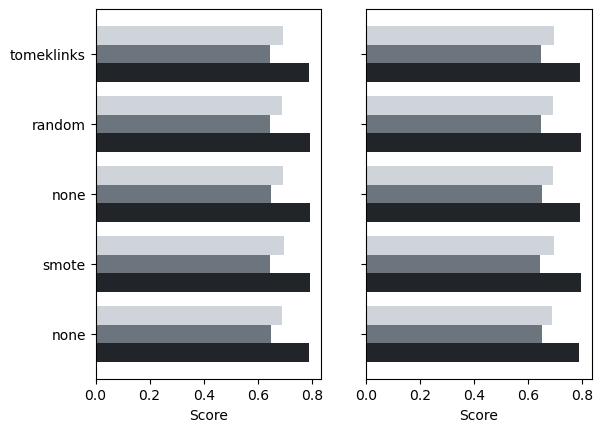

In [38]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

# Split pipeline into oversampling and undersampling
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
plot_grouped_bars(dat, "RF", axs[0])
    
# dat = grid_best_stats.query(q + " and model == 'svm'").copy()
print(pd.unique(dat["pipe_name"]))
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
plot_grouped_bars(dat, "SVM", axs[1])

### Max values by balanced accuracy and RF

In [39]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.864671,0.874890,0.864671
smote,0.867140,0.872732,0.867140


### Max values by balanced accuracy and SVM

In [40]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'svm'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.907427,0.907427,0.907427
smote,0.900002,0.900002,0.900002


## Assessing Scores

Create one plot per model, showing the balanced accuracy metrics across the three datasets.

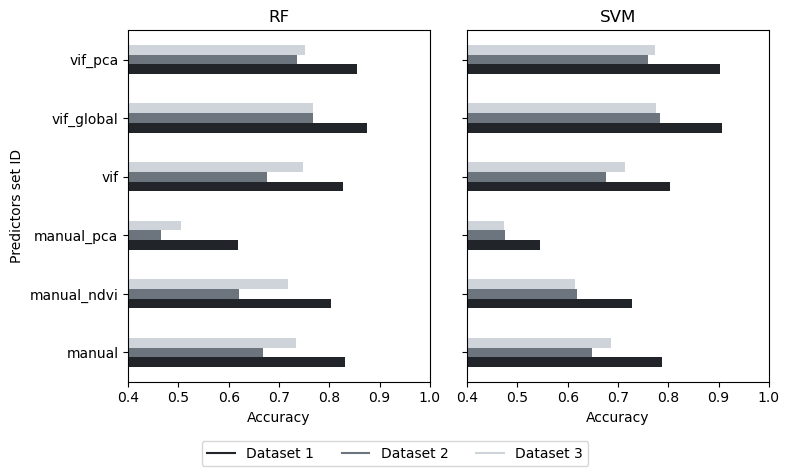

In [41]:
# Plot comparing the two approaches by model and metric
colors = ["#212529", "#6c757d", "#ced4da"]
# colors = ['#a6cee3','#1f78b4','#b2df8a']
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
for i, model in enumerate(pd.unique(grid_best_stats["model"])):
    query = f"(label_code.isnull()) and (model == '{model}') and (metric == 'balanced_accuracy')"
    data = grid_best_stats.query(query).groupby(["dataset", "pred_id"]).max().unstack("pred_id")["data"]
    data.T.sort_index().plot(kind="barh", ax=axs[i], color=colors, legend=False)
    axs[i].set_title(model.upper())
    axs[i].set_xlabel("Accuracy")
    axs[i].set_ylabel("Predictors set ID")
    axs[i].set_xlim([.4, 1])

# Cambiar el titulo de "species", son comunidades vegetales
# plt.legend(title="Species")
leg_handles, leg_labels = [], []
for label, color in zip(["Dataset 1", "Dataset 2", "Dataset 3"], colors):
    leg_handles.append(
        axs[0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
plt.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend
# Save the figure as an SVG file
# plt.savefig(Path(graphics_path, 'dataset_2_overall_metrics_by_pred.svg'), format='svg')

## Classification Error Metrics by Label

Classification errors for each label were assessed using **Producer’s Accuracy** and **User’s Accuracy**.

- **Producer’s Accuracy**: Measures how well reference sites of a given label are correctly classified.  
  It is equivalent to *100 minus the omission error*, i.e., the percentage of reference sites for that label that are not omitted.

- **User’s Accuracy**: Measures the reliability of a given label assignment in the classification.  
  It is equivalent to *100 minus the commission error*, i.e., the percentage of sites classified as a given label that are not misclassified.


In [12]:
def get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        model_key,
        pred_id,
        dataset_v):
    """
    Retrieve classification accuracy data (OA and others) for the best predictors.

    Parameters
    ----------
    grid_best_stats : pd.DataFrame
        DataFrame containing statistics of grid search results.
    label_codes : pd.DataFrame
        DataFrame mapping label codes to reclassified codes.
    best_grids : dict
        Dictionary where keys are dataset identifiers and values are dicts with
        at least 'model' and 'pred_id' keys.

    Returns
    -------
    pd.DataFrame
        Grouped DataFrame with maximum classification accuracies by dataset, metric, and label_rc_code.
    """
    # Build the query string template
    fquery = "((model == '{}') and (pred_id == '{}') and (dataset == {}))"

    # Join label codes into stats dataframe
    df = grid_best_stats.join(
        label_codes.set_index("code_v1_reclass")["label_rc_code"],
        on="label_code"
    )
    
    # Filter for producer and user accuracies
    cls_err = df.query(fquery.format(model_key, pred_id, dataset_v))
    cls_err = cls_err.query("metric in ('producer_acc', 'user_acc')")

    # Group and take max per dataset/metric/label
    cls_data = cls_err.groupby(["dataset", "metric", "label_rc_code"]).max()

    return cls_data


In [24]:
g_kappa = grid_best_stats.query("metric=='kappa'")
cls_data = g_kappa.loc[
    g_kappa.groupby(["model", "dataset"])["data"].idxmax()
].sort_values(by=["data", "dataset"], ascending=False)

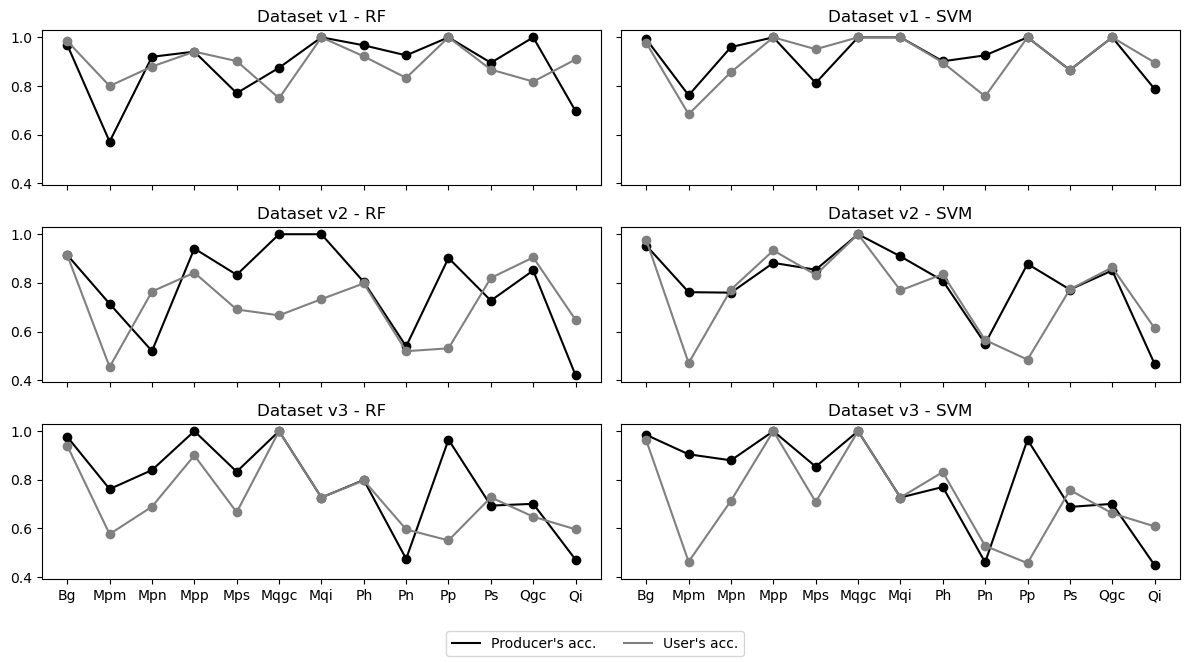

In [44]:
# Best models by Kappa metric per dataset
fig, axs = plt.subplots(3, 2, figsize=(12,7), sharey=True, sharex=True)

i = 0
for r_id, col_values in cls_data.query("model == 'rf'").iterrows():
    plot_data = get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        col_values["model"],
        col_values["pred_id"],
        col_values["dataset"]
    )

    axs[i, 0].plot(
        plot_data.loc[(col_values["dataset"], 'producer_acc'), "data"],
        color="black",
        marker='o'
    )
    axs[i, 0].plot(
        plot_data.loc[(col_values["dataset"], 'user_acc'), "data"],
        color="grey",
        marker='o'
    )
    axs[i, 0].set_title(f"Dataset v{i+1} - RF")
    i=i+1

i = 0
for r_id, col_values in cls_data.query("model == 'svm'").iterrows():
    plot_data = get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        col_values["model"],
        col_values["pred_id"],
        col_values["dataset"]
    )

    axs[i, 1].plot(
        plot_data.loc[(col_values["dataset"], 'producer_acc'), "data"],
        color="black",
        marker='o'
    )
    axs[i, 1].plot(
        plot_data.loc[(col_values["dataset"], 'user_acc'), "data"],
        color="grey",
        marker='o'
    )
    axs[i, 1].set_title(f"Dataset v{i+1} - SVM")
    i=i+1

# Cambiar el titulo de "species", son comunidades vegetales
# plt.legend(title="Species")
leg_handles, leg_labels = [], []
for label, color in zip(["Producer's acc.", "User's acc."], ["black", "grey"]):
    leg_handles.append(
        axs[0, 0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
fig.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend

# Save the figure as an SVG file
plt.savefig(Path(graphics_path, 'accuracy_by_cls.svg'), format='svg')

## Confusion Matrix

In [45]:
def show_cm(cm_dict, labels):

    # Join confusion matrix label codes with their names
    cm_labels = pd.DataFrame(cm_dict['labels'], columns=["code"])
    cm_labels = cm_labels.join(labels.set_index("code_v1_reclass"), on="code")
    
    # Create a custom dataframe with data and real labels
    cm = pd.DataFrame(cm_dict["cm"],
                      index=cm_labels['label_rc_code'], columns=cm_labels['label_rc_code'])

    title = f"{cm_dict["model"]} | {cm_dict["pipe"]} | {cm_dict["pred_id"]}"
    cmatrix(cm).pp_matrix(cmap="gray_r", fz=7, pred_val_axis='col',
                          figsize=[6, 6], cmtitle=title)

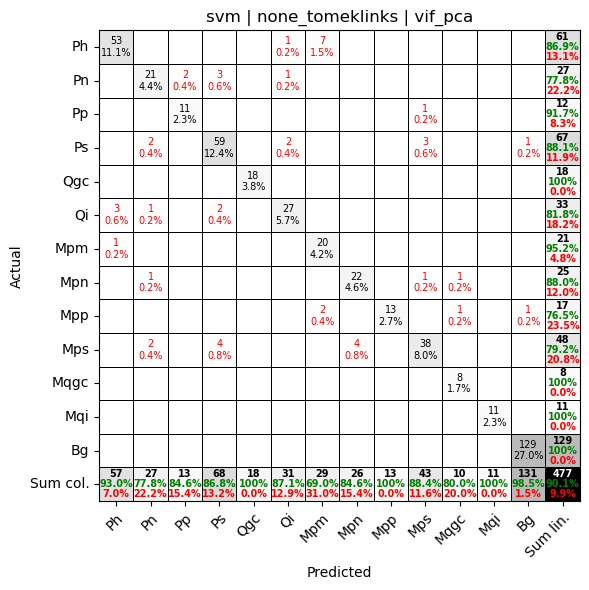

In [46]:
target_cm = search_dict(cm_stats, best_grids[1])
show_cm(target_cm, label_codes)

## SHapley Additive exPlanations

[SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) provides both global feature importance (which features matter most across the dataset) and local explanations (which features drive an individual prediction).

In [51]:
# Import labels and apply pretreatments described in inspect_predictors.ipynb
labels_dataset_path = Path(ROOT, "results/dataset.gpkg")

dataset = Dataset(labels_dataset_path, label_codes_path, 1)

In [57]:
best_grids[1]["pred_id"] + "_1"

'vif_pca_1'

In [58]:
dataset_v = 1
X_train, X_test, y_train, y_test = dataset.split(
    best_grids[dataset_v]["pred_id"] + "_" + str(dataset_v), "code_v1_reclass")
pred_vars = X_train.columns.to_list()

over, under = best_grids[dataset_v]["pipe"].split("_")
# Construct pipeline
if ("N" in pred_vars) and (over == "smote"):
    pipe = Pipeline(
        y_train,
        under,
        over,
        X_train,
        categorical_predictors=pred_vars["C"])
else:
    pipe = Pipeline(y_train, under, over)

model = Model(best_grids[dataset_v]["model"])
model.add_params(best_grids[dataset_v]["best_params"])
model.get_clf().fit(X_train, y_train)

SVC(C=25, class_weight='balanced', probability=True, random_state=42)

### SVM SHAP

In [60]:
# SHAP doesn’t have a specialized explainer for SVMs.
# KernelExplainer is mandatory, which is model-agnostic but slower
# KernelExplainer (model-agnostic)
explainer = shap.KernelExplainer(
    model.get_clf().predict_proba, X_train.sample(50, random_state=42))
# background dataset = 50 samples for efficiency

# Compute SHAP values for a subset of test data (computationally expensive)
shap_values = explainer.shap_values(X_test.iloc[:30, :])

  0%|          | 0/30 [00:00<?, ?it/s]

### Tree SHAP

In [28]:
# SHAP has a fast, optimized algorithm for tree classifiers
# SHAP explainer for tree models
explainer = shap.TreeExplainer(model.get_clf())

# Multiclass problem:
# shap_values will be a list with one array per class,
# each of shape (n_samples, n_features)
shap_values = explainer.shap_values(X_train)

### SHAP values

In [61]:
# --- Option 1: aggregate across classes ---
# Take absolute values, mean over samples and classes
mean_abs_shap_per_feature = np.mean(np.abs(shap_values), axis=(0, 2))
max_abs_shap_per_feature = np.max(np.abs(shap_values), axis=(0, 2))

# --- Option 2: keep per-class importance ---
# Take absolute values, mean over samples only
mean_abs_shap_per_feature_class = np.mean(np.abs(shap_values), axis=0)

In [62]:
shap_abs_vals = pd.DataFrame({
    "abs_max": mean_abs_shap_per_feature,
    "abs_mean": max_abs_shap_per_feature
}, index=X_train.columns).sort_values(by=["abs_mean"])

<BarContainer object of 8 artists>

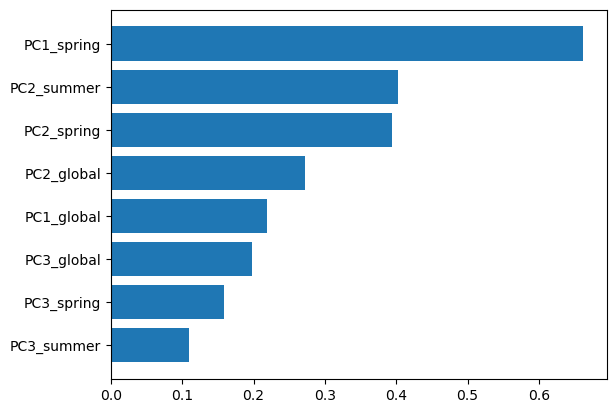

In [65]:
fig, axs = plt.subplots(1, 1, sharey=True)

axs.barh(shap_abs_vals.index, shap_abs_vals["abs_mean"])

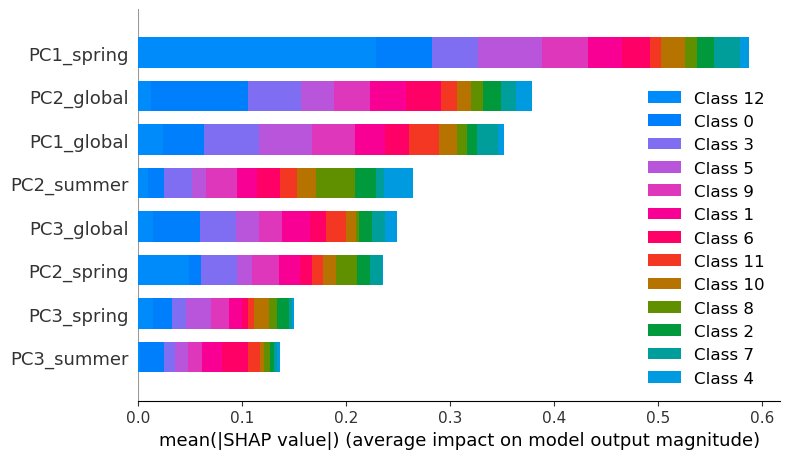

In [66]:
# Global importance bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")